# Описание проекта

**Данные для анализа:**  данные о небольшой выборке клиентов (500 человек) федерального оператора сотовой связи «Мегалайна».

**Цель:** Выявить какой из двух тарифов Smart или Ultra приносит больше денег.

**Задачи:** Провести анализ поведения пользователей в зависимости от тарифа - кто они, откуда, каким тарифом пользуются, сколько 
звонков и сообщений каждый отправил за 2018 год. Провести сравнение получаемой выручки от различных тарифов. 

**Заказчик:** Коммерческому отделу компании «Мегалайн» требуется предварительный анализ тарифов, чтобы скорректировать рекламный бюджет

# Загрузка и описание данных 

In [1]:
import pandas as pd
from io import BytesIO
import requests
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
spreadsheet_id = '1-6z-HxHsKSLXiz0aQxjbhFnkS3iYNvAVrAtgYVtu8Ww'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
calls = pd.read_csv(BytesIO(r.content))
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
spreadsheet_id = '1T9VDOJn3UIxrAqWGB3FMQKvjNNRMQ0-NkS0Kl3Xcw3M'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
internet = pd.read_csv(BytesIO(r.content))
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [4]:
spreadsheet_id = '1FHns_rkThbRaiFlp8FMMv7jE9FJks9nDnAyUbd0KwaE'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
messages = pd.read_csv(BytesIO(r.content))
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [5]:
spreadsheet_id = '1tgrp6qzb2fXN92yGUyP11x2KK25eUDGaBd6KyJ7a1NU'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
tarrifs = pd.read_csv(BytesIO(r.content))
tarrifs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [6]:
spreadsheet_id = '1Xcr0vlAXVoKpxfa71jI9y-k7V9ggotnWEE95Zn6Q4eM'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
users = pd.read_csv(BytesIO(r.content))
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Предоставлены следующие данные для анализа:  
   * `calls` - id и дата звонка с длительностью созвона и с привязкой к id пользователя  
   * `internet` - id и дата сессии проведенной в интернете с кол-ом использованного трафика с привязкой к id пользователя
   * `messages` - id и дата отправленного сообщения с привязкой к id пользователя
   * `tarrifs` - подробные данные о предлагаемых тарифах 
   * `users` - информация о пользователях: id, возраст, дата отказа от услуг оператора (если такое произошло), город, ФИО, дата регистрации и подключенный тариф
   
   

# Предобработка данных

## Тип данных

Проверим все ли данные соответсвуют необходимому типу для удобства дальнейше работы

In [7]:
calls.info()

# поменять тип в колонке с датой
# поменять тип user_id с int на string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [8]:
internet.info()

# поменять тип в колонке с датой
# поменять тип user_id с int на string
# удалить первую колонку, которая дублирует индексы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [9]:
messages.info()

# поменять тип в колонке с датой
# поменять тип user_id с int на string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [10]:
tarrifs.info()

# все типы данных корректны

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [11]:
users.info()

# поменять тип в колонках с датой
# поменять тип user_id с int на string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [12]:
# Переведем колонки с датой в тип datetime
calls['call_date'] = pd.to_datetime(calls['call_date']) 
internet['session_date'] = pd.to_datetime(internet['session_date']) 
messages['message_date'] = pd.to_datetime(messages['message_date']) 
users['churn_date'] = pd.to_datetime(users['churn_date']) 
users['reg_date'] = pd.to_datetime(users['reg_date']) 

In [13]:
# Переводим user_id из int в str
calls['user_id'] = calls['user_id'].astype(str) 
internet['user_id'] = internet['user_id'].astype(str)
messages['user_id'] = messages['user_id'].astype(str)
users['user_id'] = users['user_id'].astype(str)
users['user_id'] = users['user_id'].astype(str)

In [14]:
# Удаляем лишнюю колонку, дублирующую индексы датафрейма
internet = internet.drop(['Unnamed: 0'], axis=1)

## Дубликаты и пропущенные значения

Пропущенные значения наблюдаем только в таблице `users` в колонке `churn_date`. Значение в этой колонке присутствует только у тех пользователей, которые отказались от услуг данного телеком оператора. Соответсвенно у остальных данные в колонке отсутсвуют

In [15]:
users.duplicated().sum()

0

In [16]:
messages.duplicated().sum()

0

In [17]:
internet.duplicated().sum()

0

In [18]:
calls.duplicated().sum()

0

Явные дубликаты в таблицах также отсутсвуют. 

## Аномальные значения

In [19]:
calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

Все значения продолжительности разговора находятся в пределах разумного, отсутствие выбросов скорее вызывает недоумение. Самый продолжительный разговор достигает 38 минут. Возможно данные уже заранее были подготовлены, и аномально длинные созвоны были отсеяны. 

Отрицательные значения отсутствует, нулевые значения обозначают пропущенные звонки

In [20]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

<AxesSubplot:>

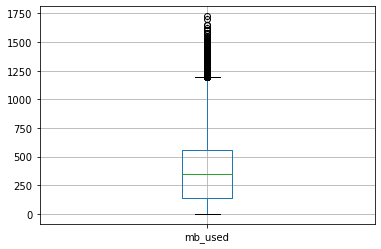

In [21]:
internet.boxplot(['mb_used'])

In [22]:
internet.query('mb_used == 0')['mb_used'].count()
# Всего наблюдаем 19598 сессий с нулевым трафиком. 

19598

Аналогичная ситуация с интренет трафиком. Аномальные значения отсутствуют. 

Однако, наблюдаем около 20тыс сессий с нулевым трафиком. Для чего эти сессии отмечены в датасете?
Возможно это какой-то баг с несколькими пользователями?

In [23]:
internet.query('mb_used == 0')['user_id'].unique()

array(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007',
       '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015',
       '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023',
       '1024', '1025', '1026', '1027', '1028', '1029', '1030', '1031',
       '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039',
       '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047',
       '1048', '1049', '1050', '1051', '1052', '1053', '1054', '1055',
       '1056', '1057', '1058', '1059', '1060', '1061', '1062', '1063',
       '1064', '1065', '1066', '1067', '1068', '1069', '1070', '1071',
       '1072', '1073', '1074', '1075', '1076', '1077', '1078', '1079',
       '1080', '1081', '1082', '1083', '1084', '1085', '1086', '1087',
       '1088', '1089', '1090', '1091', '1092', '1093', '1094', '1095',
       '1096', '1097', '1098', '1099', '1100', '1101', '1102', '1103',
       '1104', '1105', '1106', '1107', '1108', '1109', '1110', '1111',
      

Видим, что буквально у каждого пользователя бывают сессии с нулевым трафиком. 
Предлагаем убрать из датасета строки с нулевым трафиком, так как они не несут для нас никакой полезной информации. 

In [24]:
internet = internet[internet['mb_used'] > 0]
internet['mb_used'].describe()

count    129798.000000
mean        426.087210
std         255.596447
min           0.030000
25%         227.460000
50%         400.540000
75%         592.947500
max        1724.830000
Name: mb_used, dtype: float64

In [25]:
users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

Возраст пользователей начинается от 18 лет, и в выборке отсутствуют люди старше 75 лет. Аномалий нет. Идем дальше

## Дополнительная проверка качества данных

Подробнее изучим таблицу с данными о пользователях (users): 

   * Убедимся, что написание населенных пунктов корректное
   * Убедимся, что в таблицу действительно включены пользователи только двух тарифов (smart и ultra)

In [26]:
users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

Написание населенных пунктов унифицированно. Отсутсвуют одинаковые пункты с различным написанием 

In [27]:
users['tariff'].unique()

array(['ultra', 'smart'], dtype=object)

Все корректно. В таблице наблюдаем пользователей двух тарифов, которые необходимо исследовать

## Расчет и добавление параметров для анализа

### Количество сделанных звонков и израсходованных минут разговора по месяцам


Обратим внимание на примечание к данным:

«Мегалайн» всегда округляет секунды до минут. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.




Округлим все звонки до минут вверх 

In [28]:
calls['duration_rounded'] = calls['duration'].apply(lambda x: math.ceil(x))

Теперь непосредственно посчитаем кол-во звонком и минут, сгруппировав данные  по пользователям и месяцу

In [29]:
# Вытащим из даты месяц
calls['month'] = calls['call_date'].dt.month

In [30]:
calls_by_month = calls.groupby(
    ['user_id', 'month']).agg(
    {'id':'count', 'duration_rounded':'sum'}).reset_index().rename(
    columns={'id': 'calls_cnt'})
calls_by_month.head(10)

,user_id,month,calls_cnt,duration_rounded
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466
5,1000,10,57,350
6,1000,11,43,338
7,1000,12,46,333
8,1001,11,59,430
9,1001,12,63,414


### Количество отправленных сообщений по месяцам

Аналогично посчитаем кол-во отправленных сообщений по месяцам для каждого пользователя

In [31]:
# Вытащим из даты месяц
messages['month'] = messages['message_date'].dt.month 

In [32]:
messages_by_month = messages.groupby(
    ['user_id', 'month']).agg(
    {'id':'count'}).reset_index().rename(
    columns={'id':'messages_cnt'})
messages_by_month.head(10)

,user_id,month,messages_cnt
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


### Объем израсходованного интернет-трафика по месяцам

Повторяем схему с интренет-трафиком

In [33]:
# Вытащим из даты месяц
internet['month'] = internet['session_date'].dt.month 

In [34]:
internet_by_month = internet.groupby(
    ['user_id', 'month']).agg(
    {'mb_used':'sum'}).reset_index()
internet_by_month

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
...,...,...,...
3196,1498,10,20579.36
3197,1499,9,1845.75
3198,1499,10,17788.51
3199,1499,11,17963.31


Обращаемся ко второму примечанию:

«Мегалайн» всегда округляет мегабайты — до гигабайт. Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

Для дальнейшего удобства округлим трафик до ближайшего кол-ва ГБ вверх. 

In [35]:
internet_by_month['gb_used'] = internet_by_month['mb_used'].apply(lambda x: math.ceil(x/1024))
internet_by_month.head()

,user_id,month,mb_used,gb_used
0,1000,5,2253.49,3
1,1000,6,23233.77,23
2,1000,7,14003.64,14
3,1000,8,14055.93,14
4,1000,9,14568.91,15


### Помесячную выручку с каждого пользователя

Для начала объединим таблицы, чтобы получить профиль пользователей по месяцам с информацией об использованном трафике, сообщениях, звонках.  

In [36]:
# Проводим объединение в несколько шагов
messages_calls = (messages_by_month.merge(
    calls_by_month, left_on=['user_id', 'month'],
    right_on=['user_id', 'month'], how='outer'))
messages_calls.head()

,user_id,month,messages_cnt,calls_cnt,duration_rounded
0,1000,5,22.0,22.0,159.0
1,1000,6,60.0,43.0,172.0
2,1000,7,75.0,47.0,340.0
3,1000,8,81.0,52.0,408.0
4,1000,9,57.0,58.0,466.0


In [37]:
mes_calls_net = (
    messages_calls.merge(
        internet_by_month, on=['user_id', 'month'], how='outer'))
mes_calls_net.head()

,user_id,month,messages_cnt,calls_cnt,duration_rounded,mb_used,gb_used
0,1000,5,22.0,22.0,159.0,2253.49,3.0
1,1000,6,60.0,43.0,172.0,23233.77,23.0
2,1000,7,75.0,47.0,340.0,14003.64,14.0
3,1000,8,81.0,52.0,408.0,14055.93,14.0
4,1000,9,57.0,58.0,466.0,14568.91,15.0


In [38]:
users_profile = (
    mes_calls_net.merge(
        users[['user_id', 'tariff', 'reg_date', 'churn_date', 'city']], on='user_id')) 
users_profile.head()

,user_id,month,messages_cnt,calls_cnt,duration_rounded,mb_used,gb_used,tariff,reg_date,churn_date,city
0,1000,5,22.0,22.0,159.0,2253.49,3.0,ultra,2018-05-25,NaT,Краснодар
1,1000,6,60.0,43.0,172.0,23233.77,23.0,ultra,2018-05-25,NaT,Краснодар
2,1000,7,75.0,47.0,340.0,14003.64,14.0,ultra,2018-05-25,NaT,Краснодар
3,1000,8,81.0,52.0,408.0,14055.93,14.0,ultra,2018-05-25,NaT,Краснодар
4,1000,9,57.0,58.0,466.0,14568.91,15.0,ultra,2018-05-25,NaT,Краснодар


Получены профили пользователей. Теперь добавим к этим данным информацию о тарифах. 

In [39]:
services_use = (
    users_profile.merge(
        tarrifs, left_on='tariff', right_on='tariff_name'))
services_use.head()

,user_id,month,messages_cnt,calls_cnt,duration_rounded,mb_used,gb_used,tariff,reg_date,churn_date,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5,22.0,22.0,159.0,2253.49,3.0,ultra,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1,ultra
1,1000,6,60.0,43.0,172.0,23233.77,23.0,ultra,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1,ultra
2,1000,7,75.0,47.0,340.0,14003.64,14.0,ultra,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1,ultra
3,1000,8,81.0,52.0,408.0,14055.93,14.0,ultra,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1,ultra
4,1000,9,57.0,58.0,466.0,14568.91,15.0,ultra,2018-05-25,NaT,Краснодар,1000,30720,3000,1950,150,1,1,ultra


In [40]:
# Переводим информацию о бесплатном лимите на интренет-трафик 
# из мегабайт в гигабайты. 
services_use['gb_per_month_included'] = services_use['mb_per_month_included'].apply(lambda x: x/1024) 

Найдем кол-во звонков, СМС и интернет-трафика превышающие бесплатный лимит.

In [41]:
services_use['messages_over_limit'] = services_use['messages_cnt'] - services_use['messages_included']
# В случае наличия недоиспользованного лимита значение в столбце обнуляем 
services_use.loc[services_use['messages_over_limit'] < 0, 'messages_over_limit'] = 0 

In [42]:
services_use['calls_over_limit'] = services_use['duration_rounded'] - services_use['minutes_included']
# В случае наличия недоиспользованного лимита значение в столбце обнуляем 
services_use.loc[services_use['calls_over_limit'] < 0, 'calls_over_limit'] = 0

In [43]:
services_use['internet_over_limit'] = services_use['gb_used'] - services_use['gb_per_month_included']
# В случае наличия недоиспользованного лимита значение в столбце обнуляем 
services_use.loc[services_use['internet_over_limit'] < 0, 'internet_over_limit'] = 0

Находим выручку отдельно от звонков, интернет-трафика и сообщений сверх бесплатного лимита

In [44]:
services_use['calls_profit'] = services_use['calls_over_limit']*services_use['rub_per_minute']
services_use['internet_profit'] = services_use['internet_over_limit']*services_use['rub_per_gb'] 
services_use['messages_profit'] = services_use['messages_over_limit']*services_use['rub_per_message']

Находим помесячную выручку с каждого пользователя 

In [45]:
services_use['profit'] = services_use[['rub_monthly_fee', 'calls_profit', 'messages_profit', 'internet_profit']].sum(axis=1)                   
services_use.head()

,user_id,month,messages_cnt,calls_cnt,duration_rounded,mb_used,gb_used,tariff,reg_date,churn_date,...,rub_per_minute,tariff_name,gb_per_month_included,messages_over_limit,calls_over_limit,internet_over_limit,calls_profit,internet_profit,messages_profit,profit
0,1000,5,22.0,22.0,159.0,2253.49,3.0,ultra,2018-05-25,NaT,...,1,ultra,30.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
1,1000,6,60.0,43.0,172.0,23233.77,23.0,ultra,2018-05-25,NaT,...,1,ultra,30.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
2,1000,7,75.0,47.0,340.0,14003.64,14.0,ultra,2018-05-25,NaT,...,1,ultra,30.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
3,1000,8,81.0,52.0,408.0,14055.93,14.0,ultra,2018-05-25,NaT,...,1,ultra,30.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
4,1000,9,57.0,58.0,466.0,14568.91,15.0,ultra,2018-05-25,NaT,...,1,ultra,30.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0


# Анализ данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Сгруппируем данные по пользователям, месяцу и тарифу. Это позволяет найти сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц

In [46]:
data_by_user_tariff_month = (
    services_use.groupby(['user_id','month','tariff', 'city'])[['duration_rounded', 'gb_used', 'messages_cnt']].sum().reset_index())
    
data_by_user_tariff_month.head(10)

,user_id,month,tariff,city,duration_rounded,gb_used,messages_cnt
0,1000,5,ultra,Краснодар,159.0,3.0,22.0
1,1000,6,ultra,Краснодар,172.0,23.0,60.0
2,1000,7,ultra,Краснодар,340.0,14.0,75.0
3,1000,8,ultra,Краснодар,408.0,14.0,81.0
4,1000,9,ultra,Краснодар,466.0,15.0,57.0
5,1000,10,ultra,Краснодар,350.0,15.0,73.0
6,1000,11,ultra,Краснодар,338.0,15.0,58.0
7,1000,12,ultra,Краснодар,333.0,10.0,70.0
8,1001,11,smart,Москва,430.0,18.0,0.0
9,1001,12,smart,Москва,414.0,14.0,0.0


## Среднее, дисперия, стандартное отклонение

Расчитаем среднее, дисперсию и стандартное отклонение по кол-ву минут разговора, кол-ву сообщений, объему интренет-трафика для каждого тарифа

### Количество минут разговора

In [47]:
mean_calls_smart = data_by_user_tariff_month.query('tariff == "smart"')['duration_rounded'].mean()
mean_calls_smart

417.9349484073576

In [48]:
data_by_user_tariff_month.query('tariff == "ultra"')['duration_rounded'].mean()

526.6233502538071

In [49]:
np.var(data_by_user_tariff_month.query('tariff == "smart"')['duration_rounded'], ddof=1)

36219.315784344246

In [50]:
np.var(data_by_user_tariff_month.query('tariff == "ultra"')['duration_rounded'], ddof=1)

100873.63339730092

In [51]:
np.std(data_by_user_tariff_month.query('tariff == "smart"')['duration_rounded'], ddof=1)

190.3137298892128

In [52]:
np.std(data_by_user_tariff_month.query('tariff == "ultra"')['duration_rounded'], ddof=1)

317.6060978591263

### Количество сообщений

In [53]:
mean_sms = data_by_user_tariff_month.query('tariff == "smart"')['messages_cnt'].mean()
mean_sms

33.384028712427096

In [54]:
data_by_user_tariff_month.query('tariff == "ultra"')['messages_cnt'].mean()

49.36345177664975

In [55]:
np.var(data_by_user_tariff_month.query('tariff == "smart"')['messages_cnt'], ddof=1)

796.8129584480083

In [56]:
np.var(data_by_user_tariff_month.query('tariff == "ultra"')['messages_cnt'], ddof=1)

2285.2661425446836

In [57]:
std_sms_smart = np.std(data_by_user_tariff_month.query('tariff == "smart"')['messages_cnt'], ddof=1)
std_sms_smart

28.22787555676141

In [58]:
np.std(data_by_user_tariff_month.query('tariff == "ultra"')['messages_cnt'], ddof=1)

47.80445735017482

### Объем интернет трафика

In [59]:
data_by_user_tariff_month.query('tariff == "smart"')['gb_used'].mean()

16.328847016599372

In [60]:
data_by_user_tariff_month.query('tariff == "ultra"')['gb_used'].mean()

19.494416243654822

In [61]:
np.var(data_by_user_tariff_month.query('tariff == "smart"')['gb_used'], ddof=1)

33.02870517811158

In [62]:
np.var(data_by_user_tariff_month.query('tariff == "ultra"')['gb_used'], ddof=1)

97.09168626965469

In [63]:
np.std(data_by_user_tariff_month.query('tariff == "smart"')['gb_used'], ddof=1)

5.747060568509052

In [64]:
np.std(data_by_user_tariff_month.query('tariff == "ultra"')['gb_used'], ddof=1)

9.853511367510299

## Гистограммы

### Количество минут разговора

Наблюдаем нормальное распределение для обоих тарифов. Оба распредлеения немного скошены справо.

У более дорогого тарифа (ultra) больше разброс в кол-ве минут. В тариф включено 3000 бесплатных минут, и судя по графику никто из пользователей этого тарифа не использует лимит полностью. Среднее значения тарифа ultra составляет только 526 минут. Наоборот, видим, что немалая доля пользователей этого тарифа пользуется звонками в меньшей степени чем пользователи второго тарифа (smart)

У второго тарифа (smart) месячный лимит на звонки составляет 500 минут. Среднее значение - 417 минут, то есть в среднем пользователи этого тарифа практически полностью расходуют лимит, значит они могут приносить дополнительный доход компании за расход минут свыше 500. 


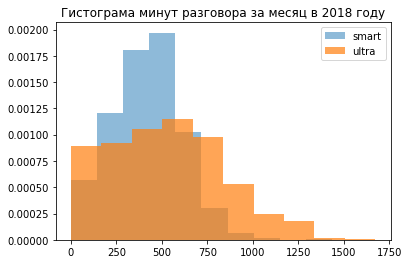

In [65]:
plt.hist(data_by_user_tariff_month.query('tariff == "smart"')['duration_rounded'], bins=10, alpha=0.5, density=True);
plt.hist(data_by_user_tariff_month.query('tariff == "ultra"')['duration_rounded'], bins=10, alpha=0.7, density=True);
plt.legend(['smart', 'ultra'])
plt.title('Гистограма минут разговора за месяц в 2018 году');

### Количество сообщений

Наблюдаем экспоненциальное распределение. Большинство пользователей не отправляют сообщения вовсе. Оправление сообщение становится наимененее востребованной услугой с появлением мессенджеров и социальных сетей.

Обратимся вновь к описанию тарифов. В тариф smart в месяц входит 50 бесплатных СМС. Среднее кол-во сообщений в месяц для этого тарифа - 33. 

В тариф ultra входит 1000 бесплатных СМС. Видим повтор ситуации со звонками. Ни один из пользователей данного тарифа не использует лимит по сообщениям полность. Максимальное кол-во сообщений в месяц не доходит даже до 300 шт.  



<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Комментарий студента:</b> Или это тоже нормальное распределение сильно скошенное вправо? Как его отличить от экспоненциального? </div>
   


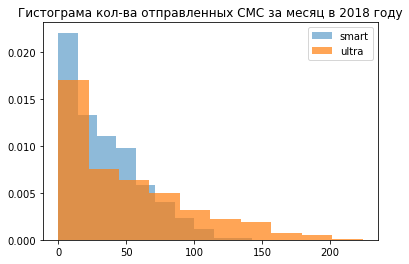

In [66]:
plt.hist(data_by_user_tariff_month.query('tariff == "smart"')['messages_cnt'], bins=10, alpha=0.5, density=True);
plt.hist(data_by_user_tariff_month.query('tariff == "ultra"')['messages_cnt'], bins=10, alpha=0.7, density=True);
plt.legend(['smart', 'ultra'])
plt.title('Гистограма кол-ва отправленных СМС за месяц в 2018 году');

### Объем интернет-трафика

Вновь наблюдаем нормальное распределение. По графику видим, что у тарифа smart маленькое отклонение, большинство значений находится рядом со средним. У более дорогого тарифа дисперсия больше.


Согласно описанию тарифов smart включает 15гб бесплатного интернета в месяц. При этом среднее значение объема трафика превышает 16гб, то есть в среднем пользователь превышает лимит, значит ему приходится доплачивать дополнительно


Тариф ultra включает в два раза больше трафика - 30гб. При этом среднее значение составляет 19.5гб. Большая часть пользователей этого тарифа укладывается в рамки бесплатного лимита. 


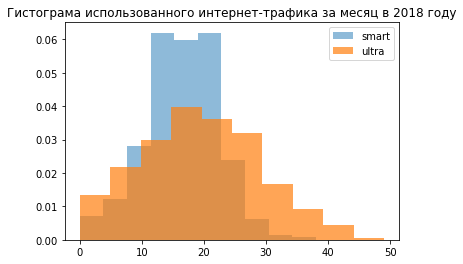

In [67]:
plt.hist(data_by_user_tariff_month.query('tariff == "smart"')['gb_used'], bins=10, alpha=0.5, density=True);
plt.hist(data_by_user_tariff_month.query('tariff == "ultra"')['gb_used'], bins=10, alpha=0.7, density=True);
plt.legend(['smart', 'ultra'])
plt.title('Гистограма использованного интернет-трафика за месяц в 2018 году');


## Вывод 

Проанализировав поведение пользователей двух тарифов и сопоставив с тарифными пакетами приходим к выводу, что у этих тарифов различный принцип действия:

1. **Тариф Smart**

Пользователи данного тарифа отдают невысокий месячный платеж. Однако, судя по графикам средний пользователь этого тарифа доплачивает за интренет, так как не вмещается в рамки бесплатного лимита. Звонки и СМС в данном тарифе также используются практически по максимуму, соответсвенно многим пользователям приходится доплачивать за них также. 

2. **Тариф Ultra**

Лимиты по звонкам и сообщениям в тарифе ultra явно установлены таким образом, чтобы пользователю не приходилось доплачивать за эти услуги дополнительно. Единственное за что пользователь потенциально будет доплачивать - интренет-трафик. Хотя большинство пользователей тарифа укладываются и в лимит интернет-трафика. 

То есть у человека будет четкое понимание, что ему раз в месяц необходимо держать на счете сумму месячного платежа - 1950 рублей. И дополнительных издержек он скорее всего не понесет



# Проверка гипотез

## Средняя выручка с пользователей тарифов Ultra и Smart различается

In [68]:
revenue_by_tariff = services_use.groupby(['user_id', 'month', 'tariff'])['profit'].sum().reset_index()
revenue_by_tariff

,user_id,month,tariff,profit
0,1000,5,ultra,1950.0
1,1000,6,ultra,1950.0
2,1000,7,ultra,1950.0
3,1000,8,ultra,1950.0
4,1000,9,ultra,1950.0
...,...,...,...,...
3209,1498,10,smart,1750.0
3210,1499,9,smart,550.0
3211,1499,10,smart,1150.0
3212,1499,11,smart,1513.0


Построили график с распределением выручки с пользователей. Как и предполагалось, видим, что по тарифу ultra подавляющее большинство пользователей оплачивают месячный платеж 1950 руб. 
У второго тарифа разброс выручки больше

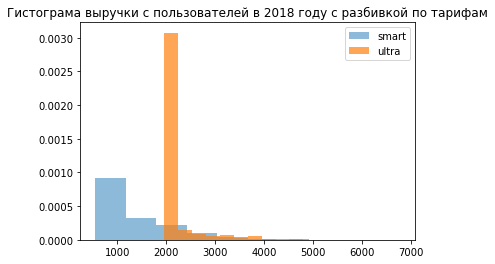

In [69]:
plt.hist(revenue_by_tariff.query('tariff == "smart"')['profit'], bins=10, alpha=0.5, density=True);
plt.hist(revenue_by_tariff.query('tariff == "ultra"')['profit'], bins=10, alpha=0.7, density=True);
plt.legend(['smart', 'ultra'])
plt.title('Гистограма выручки с пользователей в 2018 году с разбивкой по тарифам');

Найдем среднее значение выручки по данным выборкам

In [70]:
revenue_by_tariff.query('tariff == "smart"')['profit'].mean()

1289.9735307312696

In [71]:
revenue_by_tariff.query('tariff == "ultra"')['profit'].mean()

2070.1522842639592

Проверим гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам

Нулевая гипотеза всегда формулируется так, чтобы использовать знак равенства

**H0:** Средняя выручка с пользователей тарифов Ultra и Smart совпадает 

Выдвинем двухстороннюю гипотезу 

**H1:** Средняя выручка с пользователей тарифов Ultra и Smart различается

In [72]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = (st.ttest_ind(
    revenue_by_tariff.query('tariff == "smart"')['profit'], # выборка с данными выручки по тарифу smart
    revenue_by_tariff.query('tariff == "ultra"')['profit'], # выборка с данными выручки по тарифу ultra 
    equal_var=False)) # использовали дополнительный параметр, указав, что у ген совокупностей дисперсия должна отличаться. 
                      # Сделали данное предположение исходя из различного принципа действия тарифов 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


Согласно полученным результатам средняя выручка от различных тарифов все же отличается. По нашей выборки видим, что средняя выручка по тарифу smart составила 1289 рублей, по тарифу ultra 2070 рублей.

## Cредняя выручка c пользователей из Москвы отличается от выручки c пользователей из других регионов


In [73]:
# Создаем функцию разделения городов на Москву и другие

def capital(services_use):
    if services_use['city'] == 'Москва':
        return 'да'
    else:
        return 'нет'

In [74]:
# Создаем новый столбец с разделением на Москву и другие города
services_use['capital'] = services_use.apply(capital, axis=1)

In [75]:
revenue_by_city = services_use.groupby(['user_id', 'month', 'capital', 'tariff'])['profit'].sum().reset_index()
revenue_by_city

,user_id,month,capital,tariff,profit
0,1000,5,нет,ultra,1950.0
1,1000,6,нет,ultra,1950.0
2,1000,7,нет,ultra,1950.0
3,1000,8,нет,ultra,1950.0
4,1000,9,нет,ultra,1950.0
...,...,...,...,...,...
3209,1498,10,нет,smart,1750.0
3210,1499,9,нет,smart,550.0
3211,1499,10,нет,smart,1150.0
3212,1499,11,нет,smart,1513.0


In [76]:
revenue_by_city.groupby('capital').count()

,user_id,month,tariff,profit
capital,,,,
да,611,611,611,611
нет,2603,2603,2603,2603


**H0:** Cредняя выручка c пользователей из Москвы совпадает с выручкой c пользователей из других регионов

Выдвинем двухстороннюю гипотезу 

**H1:** Cредняя выручка c пользователей из Москвы отличается от выручки c пользователей из других регионов

Проверим гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам. Проверим данную гипотезу отдельно для каждого из тарифов

In [77]:
# Проверяем гипотезу для тарифа Smart 

alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = (st.ttest_ind(
    revenue_by_city.query('capital == "да" and tariff == "smart"')['profit'], # выборка с данными выручки по Москве
    revenue_by_city.query('capital == "нет" and tariff == "smart"')['profit'], # выборка с данными выручки по другим городам 
    equal_var=False)) # использовали дополнительный параметр, указав, что у ген совокупностей дисперсия должна отличаться. 
                      # Сделали данное предположение исходя из различного принципа действия тарифов 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.15468343176376667
Не получилось отвергнуть нулевую гипотезу


In [78]:
# Проверяем гипотезу для тарифа Ultra 

alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = (st.ttest_ind(
    revenue_by_city.query('capital == "да" and tariff == "ultra"')['profit'], # выборка с данными выручки по Москве
    revenue_by_city.query('capital == "нет" and tariff == "ultra"')['profit'], # выборка с данными выручки по другим городам 
    equal_var=False)) # использовали дополнительный параметр, указав, что у ген совокупностей дисперсия должна отличаться. 
                      # Сделали данное предположение исходя из различного принципа действия тарифов 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8544997530689904
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value при проверки обоих тарифов говорит о том, что вероятность получить такое или большее различие случайно велико (15% для тарифа smart и 85% для тарифа ultra). Это слишком большая вероятность, чтобы делать вывод о значимом различии между выручкой из Москвы и других городов.

**Попробуем добавить к Москве пригород - Подольск и Химки.**

In [79]:
# Создаем функцию разделения городов на Москву+Химки+Подольск и другие

def mos_reg(services_use):
    if (services_use['city'] == 'Москва' or services_use['city'] == 'Химки' or services_use['city'] == 'Подольск'):
        return 'да'
    else:
        return 'нет'

In [80]:
# Создаем новый столбец с разделением на Москву и другие города
services_use['mos_reg'] = services_use.apply(mos_reg, axis=1)

In [81]:
revenue_by_mos_reg = services_use.groupby(['user_id', 'month', 'mos_reg', 'tariff'])['profit'].sum().reset_index()
revenue_by_mos_reg


,user_id,month,mos_reg,tariff,profit
0,1000,5,нет,ultra,1950.0
1,1000,6,нет,ultra,1950.0
2,1000,7,нет,ultra,1950.0
3,1000,8,нет,ultra,1950.0
4,1000,9,нет,ultra,1950.0
...,...,...,...,...,...
3209,1498,10,нет,smart,1750.0
3210,1499,9,нет,smart,550.0
3211,1499,10,нет,smart,1150.0
3212,1499,11,нет,smart,1513.0


In [82]:
revenue_by_mos_reg.groupby('mos_reg').count()

,user_id,month,tariff,profit
mos_reg,,,,
да,628,628,628,628
нет,2586,2586,2586,2586


In [83]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = (st.ttest_ind(
    revenue_by_mos_reg.query('mos_reg == "да" and tariff == "smart"')['profit'], # выборка с данными выручки по Москве+Химкам+Подольску 
    revenue_by_mos_reg.query('mos_reg == "нет" and tariff == "smart"')['profit'], # выборка с данными выручки по другим городам 
    equal_var=False)) # использовали дополнительный параметр, указав, что у ген совокупностей дисперсия должна отличаться. 
                      # Сделали данное предположение исходя из различного принципа действия тарифов 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.05379075157657935
Не получилось отвергнуть нулевую гипотезу


In [84]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = (st.ttest_ind(
    revenue_by_mos_reg.query('mos_reg == "да" and tariff == "ultra"')['profit'], # выборка с данными выручки по Москве+Химкам+Подольску 
    revenue_by_mos_reg.query('mos_reg == "нет" and tariff == "ultra"')['profit'], # выборка с данными выручки по другим городам 
    equal_var=False)) # использовали дополнительный параметр, указав, что у ген совокупностей дисперсия должна отличаться. 
                      # Сделали данное предположение исходя из различного принципа действия тарифов 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8544997530689904
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value не позволяет отвергнуть нулевую гипотезу для обоих тарифов smart, для тарифа ultra нулевая гипотеза не отвергается. 

Однако, мы видим различия по тарифам. У тарифа smart полученное p-value имеет пограничное значение. Если увеличить критический уровень статистической значмости, то нулевую гипотезу можно было бы отвергнуть. 

In [85]:
revenue_by_mos_reg.query('mos_reg == "да" and tariff == "smart"')['profit'].mean()

1223.697270471464

In [86]:
revenue_by_mos_reg.query('mos_reg == "нет" and tariff == "smart"')['profit'].mean()

1304.6007667031763

Интересно, что средняя выручка у рассматриваемой выборки в регионах несколько выше чем в Москве. Можно предположить, что в Москве на каждом шагу есть бесплатный доступ к Wi-Fi, соответсвенно люди из регионов будут тратить больше мобильного интернет-трафика чем Москвичи.

Сравним пользователей тарифа Smart:
   1. Кол-во Москвичей по отшению к кол-ву людей из регионов, в случае когда пользователи тратят доп средства на интренет трафик 
   
   2. Кол-во Москвичей по отшению к кол-ву людей из регионов, в случае когда пользователи укладываются в бесплатный лимит
   
Если 1 < 2, то имеет место предположение про бесплатные точки Wi-Fi


In [87]:
# Кол-во Москвичей по отшению к кол-ву людей из регионов, в случае когда пользователи тратят доп средства на интренет трафик
data_by_user_tariff_month.query(
    'tariff == "smart" and gb_used > 15.0 and (city =="Москва" or city=="Химки" or city=="Подольск")')['user_id'].count() / data_by_user_tariff_month.query(
    'tariff == "smart" and gb_used > 15.0 and (city !="Москва" or city!="Химки" or city!="Подольск")')['user_id'].count()

0.17101226993865032

In [88]:
# Кол-во Москвичей по отшению к кол-ву людей из регионов, в случае когда пользователи укладываются в бесплатный лимит
data_by_user_tariff_month.query(
    'tariff == "smart" and gb_used <= 15.0 and (city =="Москва" or city=="Химки" or city=="Подольск")')['user_id'].count() / data_by_user_tariff_month.query(
    'tariff == "smart" and gb_used <= 15.0 and (city !="Москва" or city!="Химки" or city!="Подольск")')['user_id'].count()

0.1945945945945946

# Общий вывод

В исследовании проанализировали небольшую выборку (500 клиентов) телеком оператора «Мегалайн». 

Было необходимо проанализировать поведение пользователей и сделать вывод - какой из двух тарифов Smart или Ultra лучше.

***Тарифы Smart и Ultra расчитаны на людей с различным типом поведения:***

   1. **Тариф Smart**

Пользователи данного тарифа хотят получить лучшее соотношение цены-качества. Они отдают невысокий месячный платеж, при этом платят за допонительные траты по мере необходимости. Судя по графикам средний пользователь этого тарифа доплачивает за интренет, так как не вмещается в рамки бесплатного лимита. Звонки и СМС в данном тарифе также используются практически по максимуму, соответсвенно многим пользователям приходится доплачивать за них также. 

   2. **Тариф Ultra**

Пользователи этого тарифа готовы заплатить больше, при этом зачастую тратя не сильно больше лимитов чем пользователи тарифа smart. Лимиты по звонкам и сообщениям в тарифе ultra явно установлены таким образом, чтобы пользователю не приходилось беспокоиться о том, что лимит закончится в течение месяца. Единственное за что пользователь потенциально будет доплачивать - интренет-трафик. Хотя большинство пользователей тарифа укладываются и в лимит интернет-трафика. 


**Соответственно у пользователей Smart потенциально может быть сильно больше доп платежей сверх месячного тарифа. Какой же из тарифов в среднем приносит больше выручки?**

   1. Отвергнута гипотеза о том, что средняя выручка с тарифов Ultra и Smart равняется. Значит есть разница в средней выручки с этих тарифов. Судя по средней выручки тарифов преоставленной выборки, тариф ultra приносит больше дохода компании. Среднняя выручка smart - 1289 рублей, средняя выручка ultra - 2070 рублей.
 
 
   2. Не отвергнута гипотеза о том, что Для пользователей тарифа Smart отвергнута гипотеза о том, что средняя выручка c пользователей из Москвы равняется выручки c пользователей из других регионов. Однако, у тарифа Smart полученное p-value имеет пограничное значение. Если увеличить критический уровень статистической значмости, то нулевую гипотезу можно было бы отвергнуть.  И тогда получится, что пользователи Smart из регионов приносят больше выручки. 

**Рекомендации:**

Тариф Ultra приносит в среднем больше выручки. Стоит обратить внимание потенциальных пользователей именно на данный тариф.

Однако, стоит подробнее изучить эффективность рекламных затрат на привлечение пользоватей. . Выручка с нового пользователя Ultra будет выше, но и поиск  клиента на более дорогой тариф потенциально может стоить дороже. 
